**Import libraries**<br>
In this practical, we will be using the MNIST dataset of handwritten digits, which is included in the torchvision package.

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

**Set Up**<br>
Ensure that code will run on GPU or CPU by creating a device object

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

**Preparing training data**<br>
Since we are using grayscale images, we need to transform them. Thus, we will create a transform function to be used when loading the data.<br>

1.   transforms.ToTensor() converts the data to a PyTorch tensor.
2.   transforms.Normalize() converts the range of the tensor coefficients.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

**Load training data**

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

**Create data loader**

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

**Use matplotlib library to plot some samples of the training data**

[More on matplotlib](https://matplotlib.org/)

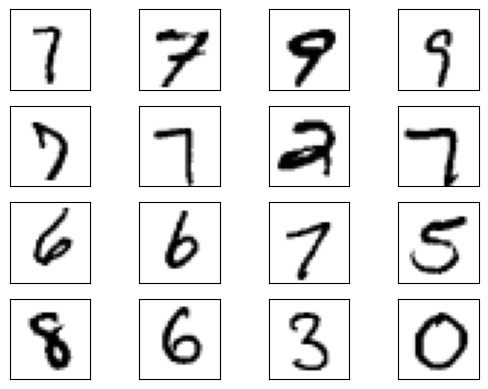

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

**Create the discriminator**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator().to(device=device)

**Create the Generator**

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

**Train the models**

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Note : will take some time to run, estimated 2 minutes per

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5665593147277832
Epoch: 0 Loss G.: 0.5045395493507385
Epoch: 1 Loss D.: 0.025640714913606644
Epoch: 1 Loss G.: 6.3424577713012695
Epoch: 2 Loss D.: 0.023191938176751137
Epoch: 2 Loss G.: 5.623356819152832
Epoch: 3 Loss D.: 0.01458896603435278
Epoch: 3 Loss G.: 6.718512535095215
Epoch: 4 Loss D.: 0.04976801201701164
Epoch: 4 Loss G.: 5.70648193359375
Epoch: 5 Loss D.: 0.08774277567863464
Epoch: 5 Loss G.: 3.7528626918792725
Epoch: 6 Loss D.: 0.3050515949726105
Epoch: 6 Loss G.: 3.5471551418304443
Epoch: 7 Loss D.: 0.24466152489185333
Epoch: 7 Loss G.: 2.757915496826172
Epoch: 8 Loss D.: 0.34373441338539124
Epoch: 8 Loss G.: 1.9983181953430176
Epoch: 9 Loss D.: 0.26385498046875
Epoch: 9 Loss G.: 2.0829591751098633
Epoch: 10 Loss D.: 0.3320910632610321
Epoch: 10 Loss G.: 2.0156569480895996
Epoch: 11 Loss D.: 0.36284393072128296
Epoch: 11 Loss G.: 1.5435575246810913
Epoch: 12 Loss D.: 0.327304482460022
Epoch: 12 Loss G.: 1.8000997304916382
Epoch: 13 Loss D.: 0.505572915

**Visualise samples generated by GAN**

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

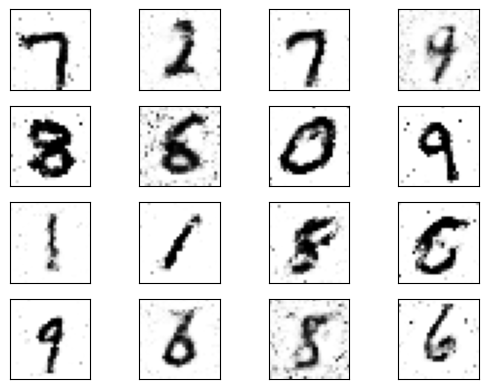

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])